In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from numpy.polynomial import Polynomial

In [2]:
import colorsys
from typing import Callable, Optional, Tuple
from numpy.typing import NDArray
from multiprocessing import Pool, cpu_count

class NewtonFractal : 

    def __init__(self, 
                 roots: Optional[NDArray[np.complexfloating]] = None, 
                 coeffs: Optional[NDArray[np.complexfloating]] = None,
                 max_iterations=1e9, tolerance=1e-3) :
        self.max_iter = int(max_iterations)
        self.tolerance = float(tolerance)

        self.saturation = 0.75

        if(roots is None) == (coeffs is None) : 
            raise ValueError("Either 'roots' or 'coeffs' must be provided.")

        if(roots is not None) : self.poly = Polynomial.fromroots(roots)
        if(coeffs is not None) : self.poly = Polynomial(coeffs)
        self.roots = self.poly.roots()

        self.dpoly: Polynomial = self.poly.deriv()

    def hue(self, z: np.complexfloating) :
        return float(np.angle(z)) / (2 * np.pi)

    def lightness(self, iters: int) :
        return 0.5 / (1.0 + 0.18 * iters)

    def perform_newton(self, x0) : 
        not_converged = True
        iters = 0
        curr_x = x0
        closest = None
        
        while not_converged and iters < self.max_iter : 
            new_x = curr_x - self.poly(curr_x)/self.dpoly(curr_x)
            
            curr_x = new_x
            iters += 1

            # Convergence test
            if np.isclose(new_x, self.roots, rtol=self.tolerance).any() : 
                root_proximity = np.abs(curr_x - self.roots)
                closest = np.argmin(root_proximity)
                not_converged = False
        
        if closest is None : 
            raise RuntimeError(f"Convergence not achieved after {iters} iterations for guess {x0}")
            
        return (self.roots[closest], iters)
    
    def compute_point(self, z: np.complexfloating) : 
        root_val, iters = self.perform_newton(z)
        return self.convert_to_rgb(root_val, iters)
    
    def convert_to_rgb(self, z: np.complexfloating, iterations: int) : 
        hls = self.hue(z), self.lightness(iterations), self.saturation
        return colorsys.hls_to_rgb(*hls)

    def generate_fractal(self, real_lim: Tuple[float, float], imag_lim: Tuple[float, float], pixels: int, cores: int = 1) : 

        reals = np.linspace(*real_lim, pixels)
        imags = np.linspace(*imag_lim, pixels)

        X, Y = np.meshgrid(reals, imags)
        Z = X + 1j * Y
        Z_flat = Z.flatten()

        #rgbs = np.ones(shape=(pixels, pixels, 3))
        nprocs = min(cores, cpu_count())
        with Pool(processes=nprocs) as pool : 
            rgb_list = list(
                tqdm(pool.imap(self.compute_point, Z_flat),
                     total=Z_flat.size,
                     desc="Computing grid..."
                     )
            )

        rgb_array = np.array(rgb_list, dtype=float)
        rgb_array = rgb_array.reshape((pixels, pixels, 3))
        
        return rgb_array
    

In [4]:
roots = np.array([
    1,
    np.exp(2j * np.pi / 3),
    np.exp(4j * np.pi / 3),
])

computer = NewtonFractal(roots=roots)
lim = 0.5
rgbs = computer.generate_fractal(real_lim=(-lim, lim), imag_lim=(-lim, lim), pixels=1000, cores=16)


Computing grid...: 100%|██████████| 1000000/1000000 [02:31<00:00, 6602.88it/s]


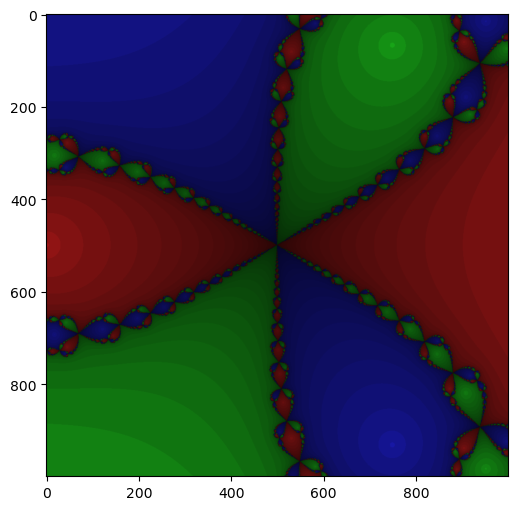

In [5]:
fig, ax = plt.subplots(figsize=(6,6))

ax.imshow(rgbs)